# Detrending Periodic Motions in Video

The goal of this notebook is to demonstrate a proof of concept for cleaning up periodic motions in videos.  If the input is a periodically oscillating blob with an additive random walk, the network will try to remove the random walk and only be left with the periodic motion

In [1]:
%load_ext autoreload
%autoreload 2
from persim import plot_diagrams
from takenslayers import *
from takenspipelines import *
from videoutils import *
import matplotlib.pyplot as plt

import math

import numpy as np
from scipy.signal import convolve
from skimage.transform import resize

import torch
from torch.autograd import Variable
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision.transforms as T

torch.manual_seed(2)

(128, 128, 3, 201)


Text(0.5, 1.0, 'Original Persistence Diagram')

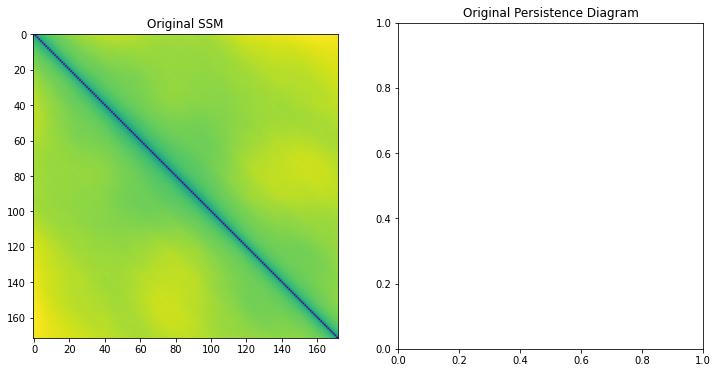

In [2]:
frames = load_video("Videos/face_128.avi", make_rgb=True)
frames = frames[:, :, :, 100::]
win = 30
print(frames.shape)

X = np.moveaxis(frames, [0, 1, 2, 3], [2, 3, 1, 0])
X = np.array(X, dtype=float)/255
downscale_fac = 1

#"""
XMu = np.mean(X, axis=1)
X -= XMu[:, None, :, :]
XMin = np.min(X, axis=1)
X -= XMin[:, None, :, :]
X /= downscale_fac
X += 0.5 - 1/(downscale_fac*2)
XOut = np.array(255*X, dtype=np.uint8)
XOut = np.moveaxis(XOut, [2, 3, 1, 0], [0, 1, 2, 3])
#save_video("MeanSubtract.avi", XOut, is_rgb=True)

#XR = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]*X.shape[3]))
#XR = np.moveaxis(XR, [0, 1, 2], [2, 0, 1])
#XR = np.reshape(XR, (XR.shape[0], XR.shape[1]*XR.shape[2]))
#print(np.std(XR, axis=1))

data = torch.from_numpy(X).float()

vid_dist = SlidingVideoDistanceMatrixLayer(win, 'cpu')
rips = RipsPersistenceDistance([1])
D = vid_dist(data)
dgm = rips(D)[0]

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(D.detach().numpy())
plt.title("Original SSM")
plt.subplot(122)
dgm = dgm.detach().numpy()
if dgm.size > 0:
    plot_diagrams(dgm, labels=["H1"])
plt.title("Original Persistence Diagram")

win =  30
cpu


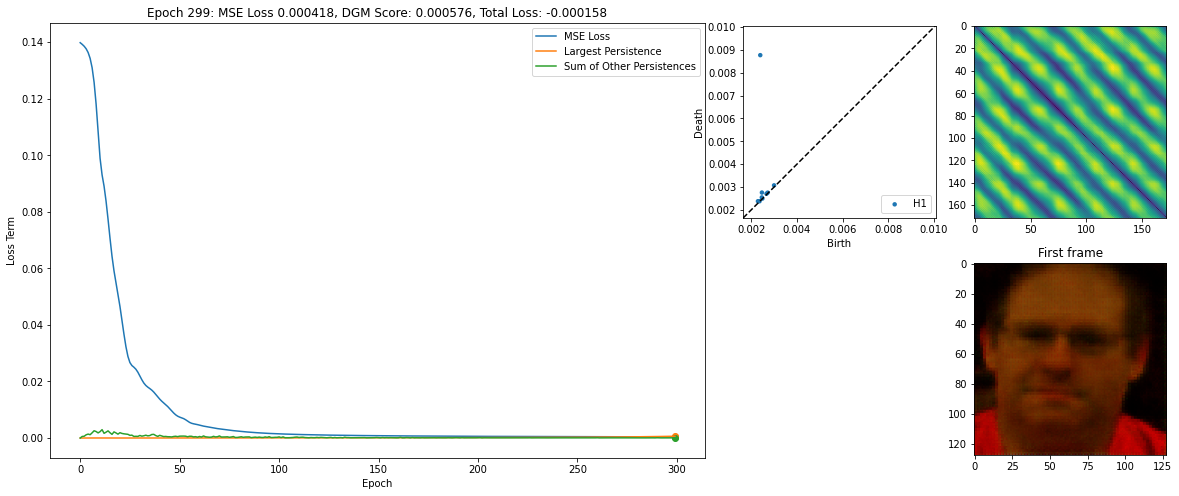

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return 'cpu'#device

print("win = ", win)
device = get_device()
print(device)
data = data.to(device)
autoencoder = RipsRegularizedAutoencoderCNN(device, data, depth=3, dim=100, win=win, lam=0.1, lr=0.001)
autoencoder = autoencoder.to(device)

y = autoencoder.train_epochs(300, plot_interval=10)

(201, 3, 128, 128)
0.2831360280513764
1.5423625882249326e-05


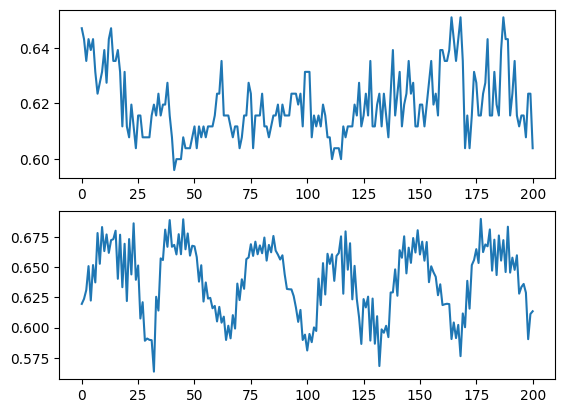

In [40]:
res = np.array(y.cpu().detach().numpy())
res -= 0.5 - 1/(downscale_fac*2)
res *= downscale_fac
#res += XMin[:, None, :, :]
#res -= np.min(res, axis=)
print(res.shape)
print(np.quantile(res, 0.8))
print(np.quantile(res, 0.1))
res *= 40
res -= 15
#res += XMu[:, None, :, :]
frames_res = np.moveaxis(res, (2, 3, 0, 1), (0, 1, 3, 2))

plt.subplot(211)
plt.plot(frames[64, 64, 0, :]/255)
plt.subplot(212)
plt.plot(frames_res[64, 64, 0, :])

In [41]:
frames_res = np.array(frames_res*255, dtype=np.uint8)
frames_res[frames_res < 0] = 0
frames_res[frames_res > 255] = 255
save_video("result.avi", frames_res, is_rgb=True)